In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df = prepare.remove_outliers(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48242 entries, 0 to 52440
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   heatingorsystemtypeid         31152 non-null  float64
 1   airconditioningtypeid         12666 non-null  float64
 2   parcelid                      48242 non-null  int64  
 3   id                            48242 non-null  int64  
 4   bathroomcnt                   48242 non-null  float64
 5   bedroomcnt                    48242 non-null  float64
 6   buildingqualitytypeid         30879 non-null  float64
 7   calculatedbathnbr             48232 non-null  float64
 8   calculatedfinishedsquarefeet  48242 non-null  float64
 9   finishedsquarefeet12          48135 non-null  float64
 10  fips                          48242 non-null  float64
 11  fullbathcnt                   48232 non-null  float64
 12  garagecarcnt                  16949 non-null  float64
 13  g

In [5]:
df = prepare.handle_nulls(df)

In [6]:
df = prepare.rename_columns(df)

In [7]:
df = prepare.prepare_locs(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   47936 non-null  int64         
 1   bathrooms                  47936 non-null  float64       
 2   bedrooms                   47936 non-null  float64       
 3   square_feet                47936 non-null  int64         
 4   fips                       47936 non-null  int64         
 5   garages                    47936 non-null  int64         
 6   garage_size                47936 non-null  int64         
 7   lot_size                   47936 non-null  int64         
 8   has_pool                   47936 non-null  bool          
 9   propertycountylandusecode  47936 non-null  object        
 10  propertylandusetypeid      47936 non-null  float64       
 11  year_built                 47936 non-null  int64         
 12  taxv

In [9]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [10]:
orange_train = train.where(train.county == 'orange')
orange_validate = validate.where(validate.county == 'orange')
orange_test = test.where(test.county == 'orange')

In [11]:
orange_train = orange_train.dropna()
orange_validate = orange_validate.dropna()
orange_test = orange_test.dropna()

In [ ]:
orange_train.info()

In [12]:
continuous_features = orange_train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size', 'year_built']]

In [13]:
discrete_features = orange_train[['has_pool', 'transaction_date', 'propertycountylandusecode']]

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

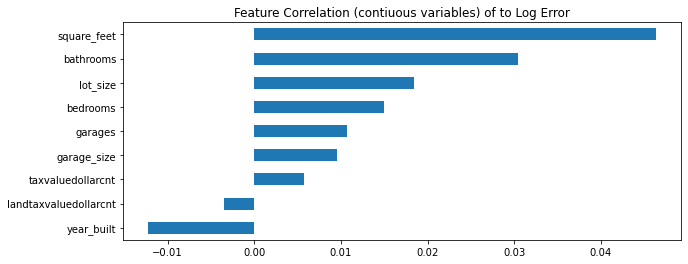

In [15]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = continuous_features.corrwith(orange_train['log_error']).sort_values().plot.barh()
corr_chart


- square feet, bathrooms, and year built - these 3 move on for modeling

In [16]:
import plotly.express as px

Text(0.5, 1.0, 'Land Code w/Cont.')

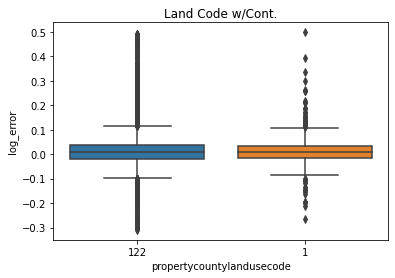

In [18]:
sns.boxplot(data=orange_train, x='propertycountylandusecode', y='log_error')
plt.title("Land Code w/Cont.")

In [19]:
orange_train.log_error.groupby(orange_train.propertycountylandusecode).mean()

propertycountylandusecode
1      0.014645
122    0.013903
Name: log_error, dtype: float64

In [20]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,propertylandusetypeid,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,log_error,latitude,longitude
count,6.863000e+03,6863.000000,6863.000000,6863.000000,6863.0,6863.000000,6863.000000,6863.000000,6863.0,6863.000000,6.863000e+03,6.863000e+03,6863.000000,6863.000000,6863.000000
mean,1.418608e+07,2.375127,3.418330,1976.051435,6059.0,1.856040,470.832872,7157.344019,261.0,1971.848754,5.082075e+05,3.432320e+05,0.013903,33.721631,-117.837948
std,1.981944e+05,0.720478,0.801846,773.033827,0.0,0.576395,158.169884,6544.453894,0.0,16.273032,3.870075e+05,3.040366e+05,0.076180,0.126055,0.135150
min,1.383453e+07,1.000000,1.000000,653.000000,6059.0,0.000000,0.000000,540.000000,261.0,1910.000000,4.006800e+04,1.327500e+04,-0.309399,33.393644,-118.111451
25%,1.401427e+07,2.000000,3.000000,1392.000000,6059.0,2.000000,420.000000,5000.000000,261.0,1961.000000,2.544235e+05,1.280910e+05,-0.018369,33.632048,-117.950374
50%,1.418736e+07,2.000000,3.000000,1804.000000,6059.0,2.000000,460.000000,6458.000000,261.0,1971.000000,4.403300e+05,2.968870e+05,0.007192,33.732138,-117.856701
75%,1.437103e+07,3.000000,4.000000,2398.000000,6059.0,2.000000,520.000000,7902.000000,261.0,1984.000000,6.580000e+05,4.674305e+05,0.035526,33.824317,-117.714816
max,1.476274e+07,5.000000,5.000000,5494.000000,6059.0,14.000000,4251.000000,296208.000000,261.0,2015.000000,2.989631e+06,2.783873e+06,0.491767,33.945897,-117.554636


In [21]:
(orange_train.where(orange_train.propertycountylandusecode == '1')).describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,propertylandusetypeid,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,log_error,latitude,longitude
count,5.050000e+02,505.000000,505.000000,505.000000,505.0,505.000000,505.000000,505.000000,505.0,505.000000,5.050000e+02,5.050000e+02,505.000000,505.000000,505.000000
mean,1.427168e+07,3.271287,3.772277,2861.055446,6059.0,2.000000,514.097030,6201.013861,261.0,2003.653465,9.740409e+05,5.137677e+05,0.014645,33.683871,-117.779306
std,1.908072e+05,0.808970,0.699790,830.189647,0.0,0.345033,118.694538,4531.934806,0.0,12.378966,4.298494e+05,3.037963e+05,0.067993,0.144146,0.131958
min,1.383882e+07,1.000000,2.000000,902.000000,6059.0,0.000000,0.000000,1027.000000,261.0,1912.000000,9.755100e+04,1.794200e+04,-0.266302,33.423443,-118.107041
25%,1.415672e+07,2.500000,3.000000,2283.000000,6059.0,2.000000,428.000000,3812.000000,261.0,2003.000000,6.947200e+05,3.270280e+05,-0.014907,33.550964,-117.869508
50%,1.432801e+07,3.000000,4.000000,2777.000000,6059.0,2.000000,466.000000,5232.000000,261.0,2005.000000,8.843200e+05,4.411170e+05,0.008090,33.681750,-117.770978
75%,1.445362e+07,4.000000,4.000000,3451.000000,6059.0,2.000000,611.000000,7187.000000,261.0,2009.000000,1.159000e+06,6.292630e+05,0.033477,33.786391,-117.643618
max,1.476217e+07,5.000000,5.000000,5438.000000,6059.0,4.000000,889.000000,56280.000000,261.0,2015.000000,2.922335e+06,2.208361e+06,0.497845,33.935358,-117.576924


In [ ]:
orange_train.garages.value_counts()

Because there are so few properties that have 3+ garages, I'm turning this into a boolean of yes/no garage and dropping garage size.

In [ ]:
orange_train['garages'] = orange_train.garages.astype(bool)

In [ ]:
orange_train.garages.value_counts()

In [ ]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).groupby(orange_train.garages).sum()

pretty much all of the homes in code 1 have garages. 

In [ ]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
orange_train_neg.groupby(orange_train_neg.has_pool).mean()

In [ ]:
orange_train_neg.describe()

In [ ]:
orange_train['has_pool'] = orange_train.has_pool.astype(int)
orange_train['garages'] = orange_train.has_pool.astype(int)

In [ ]:
bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
orange_train['log_error_bin'] = pd.cut(orange_train['log_error'], bins=bins, labels=labels)
orange_validate['log_error_bin'] = pd.cut(orange_validate['log_error'], bins=bins, labels=labels)
orange_test['log_error_bin'] = pd.cut(orange_test['log_error'], bins=bins, labels=labels)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
orange_train_neg.info()

In [ ]:
orange_train.groupby(orange_train.log_error_bin == 'N4').max()

In [ ]:
bins = [0, .0125, .0283, .0586, .6]
labels = ['P1', 'P2', 'P3', 'P4']
orange_train_pos['log_error_bin'] = pd.cut(orange_train_pos['log_error'], bins=bins, labels=labels)

In [ ]:
bins = [-.6, -.0475, -.0244, -.0106, 0.01]
labels = ['N4','N3','N2','N1']
orange_train_neg['log_error_bin'] = pd.cut(orange_train_neg['log_error'], bins=bins, labels=labels)

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train, scatter=True, col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='taxvaluedollarcnt', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
orange_train = orange_train[orange_train.lot_size < 200000]
orange_validate = orange_validate[orange_validate.lot_size < 200000]
orange_test = orange_test[orange_test.lot_size < 200000]
orange_train_pos = orange_train_pos[orange_train_pos.lot_size < 200000]
orange_train_neg = orange_train_neg[orange_train_neg.lot_size < 200000]

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train_neg.drop("log_error", axis=1).corrwith(orange_train_neg['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
orange_train['weight_lot'] = orange_train['lot_size'] * 3.5
orange_validate['weight_lot'] = orange_validate['lot_size'] * 3.5
orange_test['weight_lot'] = orange_test['lot_size'] * 3.5

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(orange_train[['weight_lot', 'square_feet']])

In [ ]:
orange_train[['scallot', 'scalsquare']] = scaler.transform(orange_train[['weight_lot', 'square_feet']])

In [ ]:
orange_validate[['scallot', 'scalsquare']] = scaler.transform(orange_validate[['weight_lot', 'square_feet']])
orange_test[['scallot', 'scalsquare']] = scaler.transform(orange_test[['weight_lot', 'square_feet']])

In [ ]:
orange_train['sqft'] = (orange_train.scallot + orange_train.scalsquare) / 2
orange_validate['sqft'] = (orange_validate.scallot + orange_validate.scalsquare) / 2
orange_test['sqft'] = (orange_test.scallot + orange_test.scalsquare) / 2

In [ ]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
datap1 = orange_train_pos[orange_train_pos.log_error_bin == 'P1']
datap2 = orange_train_pos[orange_train_pos.log_error_bin == 'P2']
datap3 = orange_train_pos[orange_train_pos.log_error_bin == 'P3']
datap4 = orange_train_pos[orange_train_pos.log_error_bin == 'P4']

In [ ]:
datan1 = orange_train_neg[orange_train_neg.log_error_bin == 'N1']
datan2 = orange_train_neg[orange_train_neg.log_error_bin == 'N2']
datan3 = orange_train_neg[orange_train_neg.log_error_bin == 'N3']
datan4 = orange_train_neg[orange_train_neg.log_error_bin == 'N4']

In [ ]:
dp1 = datap1[['bedrooms', 'bathrooms', 'sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp2 = datap2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dp3 = datap3[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp4 = datap4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
dn1 = datan1[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dn2 = datan2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn3 = datan3[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn4 = datan4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
data_pos = orange_train_pos[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]
data_neg = orange_train_neg[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
sns.pairplot(data_pos)

In [ ]:
sns.pairplot(dp3)

In [ ]:
sns.pairplot(dp4)

In [ ]:
sns.pairplot(dn4)

Log error- higher for having gargage
higher for 1 bedroom and bit higher for 5 beds
higher for 4 + bathrooms
before 1949 has higher log error
square feet - I think it's greater for small and big
very low for having a pool

not
-landusecode

In [ ]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train.drop("log_error", axis=1).corrwith(abs(orange_train['log_error'])).sort_values().plot.barh()
corr_chart

In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [ ]:
orange_train.info()

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
# inserts the 4 selected features into the scaler

orange_train_s = (orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_validate_s  = (orange_validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_test_s = (orange_test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])

orange_train_scal = scaler.transform(orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_validate_scal  = scaler.transform(orange_validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_test_scal  = scaler.transform(orange_test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])

In [ ]:
X_train_scaled = pd.DataFrame(orange_train_scal, index=orange_train_s.index, columns=orange_train_s.columns)
X_validate_scaled = pd.DataFrame(orange_validate_scal, index=orange_validate_s.index, columns=orange_validate_s.columns)
X_test_scaled = pd.DataFrame(orange_test_scal, index=orange_test_s.index, columns=orange_test_s.columns)

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

orange_train['KM'] = kmeans.predict(X_train_scaled)
orange_validate['KM'] = kmeans.predict(X_validate_scaled)
orange_test['KM'] = kmeans.predict(X_test_scaled)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_train_scaled.columns)
centroids

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(orange_train_scal).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
KM0 = orange_train.where(orange_train.KM == 0)
KM1 = orange_train.where(orange_train.KM == 1)
KM2 = orange_train.where(orange_train.KM == 2)
KM3 = orange_train.where(orange_train.KM == 3)
KM4 = orange_train.where(orange_train.KM == 4)

KM0 = KM0.dropna()
KM1 = KM1.dropna()
KM2 = KM2.dropna()
KM3 = KM3.dropna()
KM4 = KM4.dropna()

In [ ]:
KM4.describe()

In [ ]:
orange_train.describe()

In [ ]:
orange_train.groupby(orange_train.KM == '0').mean()

In [ ]:
# scaler = sklearn.preprocessing.MinMaxScaler()
# scaler.fit(orange_train[['latitude', 'longitude', 'year_built']])
# # inserts the 4 selected features into the scaler

# orange_train[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_train[['latitude', 'longitude', 'year_built']])
# orange_validate[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_validate[['latitude', 'longitude', 'year_built']])
# orange_test[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_test[['latitude', 'longitude', 'year_built']])

In [ ]:
orange_train.square_feet.groupby(orange_train.locs).mean()

In [ ]:
bins = [1900, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2020]
labels = ['1910s','1920s','1930s','1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', ]
orange_train['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_validate['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_test['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)

In [ ]:
sns.barplot(data=orange_train, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
sns.barplot(data=orange_train_pos, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
# does location matter for year matter for? only in early years and also more for negative

In [ ]:
sns.barplot(data=orange_train_neg, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
orange_train.info()

CHECKPOINT

In [ ]:
# dummy_train = pd.get_dummies(orange_train['propertycountylandusecode', 'cluster'])
# dummy_validate = pd.get_dummies(orange_validate['propertycountylandusecode', 'cluster'])
# dummy_test = pd.get_dummies(orange_test['log])

In [ ]:
X_train = orange_train[['bedrooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'has_pool','garages',  'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin 

X_test = orange_test[['bedrooms', 'has_pool', 'garages', 'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

In [ ]:
orange_train['rooms'] = (orange_train['bedrooms'] + orange_train['bathrooms'] + orange_train['garages'])
orange_validate['rooms'] = (orange_validate['bedrooms'] + orange_validate['bathrooms'] + orange_validate['garages'])
orange_test['rooms'] = (orange_test['bedrooms'] + orange_test['bathrooms'] + orange_test['garages'])

In [ ]:
orange_validate.info()

In [ ]:
X_train = orange_train[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_train = orange_train.log_error 

X_validate = orange_validate[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_validate = orange_validate.log_error

X_test = orange_test[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_test = orange_test.log_error

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=3)

f_selector.fit(X_train_scaled, y_train)

feature_mask = f_selector.get_support()
 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [ ]:
f_feature

In [ ]:
X_train = orange_train[['bedrooms', 'rooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'rooms', 'garages', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin

X_test = orange_test[['bedrooms', 'garages', 'rooms', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_train[['scalbathrooms','scalsquare_feet']] = scaler.transform(orange_train[['bathrooms', 'square_feet']])

In [ ]:
X = orange_train[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_validate[['bathrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

orange_validate[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_validate[['bathrooms', 'square_feet']])

In [ ]:
X = orange_validate[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_validate['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_test[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_test[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_test[['bathrooms', 'square_feet']])

In [ ]:
X = orange_test[['scalbathrooms',  'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_test['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
orange_train

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='bedrooms', y='bathrooms', data=orange_train, scatter=True, hue='cluster', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.barplot(data=orange_train, x='cluster', y='year_built')
plt.title("Land Code w/Cont.")

In [ ]:
orange_train

In [ ]:
dummy_train = pd.get_dummies(orange_train[['propertycountylandusecode', 'cluster']])
dummy_validate = pd.get_dummies(orange_validate[['propertycountylandusecode', 'cluster']])
dummy_test = pd.get_dummies(orange_test[['propertycountylandusecode', 'cluster']])

In [ ]:
X_train

In [ ]:
X_train = orange_train[['sqft', 'has_pool', 'rooms']]
y_train = orange_train[['log_error']]

X_validate = orange_validate[['sqft', 'has_pool', 'rooms']]
y_validate = orange_validate[['log_error']]

X_test = orange_test[['sqft', 'has_pool', 'rooms']]
y_test = orange_test[['log_error']]

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train[['sqft', 'has_pool', 'rooms']])

In [ ]:
X_train[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_train[['sqft', 'has_pool', 'rooms']]) 
X_validate[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_validate[['sqft', 'has_pool', 'rooms']]) 
X_test[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_test[['sqft', 'has_pool', 'rooms']]) 

In [ ]:
# v = pd.DataFrame(data = v)
# v1 = pd.DataFrame(data = v1)
# v2 = pd.DataFrame(data = v2)

In [ ]:
# v.index = X_train.index
# v1.index = X_validate.index
# v2.index = X_test.index

In [ ]:
# X_train = pd.concat([X_train, v], axis=1)
# X_validate = pd.concat([X_validate, v1], axis=1)
# X_test = pd.concat([X_test, v2], axis=1)

In [ ]:
X_test_scaled.head()

In [ ]:
X_train = X_train_scaled
y_train = orange_train[['log_error']]

X_validate = X_validate_scaled
y_validate = orange_validate[['log_error']]

X_test_scaled = X_test_scaled
y_test = orange_test[['log_error']]

In [ ]:
X_validate.head()

In [ ]:
y_train['pred_mean'] = y_train.log_error.mean()
y_validate['pred_mean'] = y_validate.log_error.mean()

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 4)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train.log_error)

y_train['value_predict_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)

y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)


printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train, y_train.log_error)

y_train['pred_lars'] = lars.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_lars)**(1/2)

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 4))

In [ ]:
pf = PolynomialFeatures(degree=2)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

# X_validate_degree3 = pf.transform(X_validate)
# X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [ ]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 4)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 4))